#Introduction

## Sound Clustering Assignment
This notebook performs clustering on an unlabeled dataset of 3,000 sound recordings from the `unlabelled_sounds` folder, extracts Mel Spectrogram features, applies dimensionality reduction, implements clustering algorithms, and evaluates their performance. The data is stored in `unsupervised/sound/` on my Google Drive.

# Data Loading and Feature Extraction

## Data Loading and Feature Extraction
I will use the Librosa python library to extract Mel Spectrogram features from the .wav files. The dataset is loaded from my Google Drive path `unsupervised/sound/`. Since it’s a large dataset (3,000 items), we’ll process files in batches to manage memory efficiently.

## Install and Import the necessary library
Here we are importing the essential libraries. **numpy (np)** provides numerical operations for array handling, critical for feature matrices. **librosa** is a Python library for audio and music analysis, used to extract Mel Spectrograms. **os** enables file system operations (e.g., listing files). **google.colab.drive** allows Google Drive mounting in Colab, necessary to access your unsupervised/sound/ dataset.

In [100]:
!pip install librosa

In [101]:
# Import necessary libraries
import numpy as np
import librosa
import os
from google.colab import drive
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_score, davies_bouldin_score

## Mount Google Drive

I will be defining a function to process each **audio file**, extracting **Mel Spectrogram features**, a representation of sound frequency content over time.

Mel Spectrograms capture human-audible frequency ranges, ideal for clustering sound data. The function is modular, reusable across files.

First we Load the audio file into a time-series array (y) and sample rate (sr) using **librosa.load**. **sr=sr** sets the target sample rate (default 22050 Hz) which is of high frequency, ensuring consistent sampling for feature extraction. sr resamples if the original rate differs, preserving audio quality, an we setting sr to this high frequency is because lower sr loses high frequencies, and the fact sr can resample make it easier to capture lower frequency if the audio data contains more of that during it time span.

We Compute the Mel Spectrogram next, converting the audio time series into a spectrogram with n_mels frequency bins on the Mel scale. The Mel scale aligns with human perception, making it effective for sound clustering. n_mels=128 balances detail and computation, if I used higher n_mels, this would increas my dimensionality (more features), risking overfitting or memory issues, and also lower values lose detail, so I want something in the center so i decided to go with **128**.

Next we convert the power spectrogram to decibels (dB), using the maximum value as reference (ref=np.max), enhancing contrast for visualization and analysis.
dB scaling highlights quieter sounds, improving cluster separability in high-dynamic-range audio.

In [102]:
# Mount Google Drive
drive.mount('/content/drive')

# Set data path
data_path = '/content/drive/My Drive/unsupervised/sound/unlabelled_sounds'

# Function to extract Mel Spectrogram features
def extract_mel_spectrogram(audio_path, n_mels=128, sr=22050):
    """Extract Mel Spectrogram features from an audio file."""
    try:
        y, sr = librosa.load(audio_path, sr=sr)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        # Return mean across time to get a fixed-size feature vector
        return np.mean(mel_spec_db, axis=1)
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

# Load audio files and extract features
audio_files = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith('.wav')]
X = [extract_mel_spectrogram(f) for f in audio_files if extract_mel_spectrogram(f) is not None]
X = np.array(X)  # Convert to numpy array after filtering None values

print(f"Feature matrix shape: {X.shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Feature matrix shape: (3000, 128)


# Initial Visualization
now for visualization purpose I will extracts the first 5 Mel bins for all rows and assigns descriptive names for the pair plot.Using the first 5 help limit visualization to manageable dimension, and naming improves readability, because using all 128 bins could crash the plot due to high dimensionality, but dimesions could be adjusted for more experiments.

Next we would generate a grid of scatter plots for all feature pairs, with a title positioned above (y=1.02), this could help reveal initial patterns or overlaps, guiding dimensionality reduction needs.

In [103]:
# Select a subset of features for pair plot (first 5 Mel bins)
feature_dim = 5
subset_features = X[:, :feature_dim]
feature_names = [f'Mel Bin {i+1}' for i in range(5)]

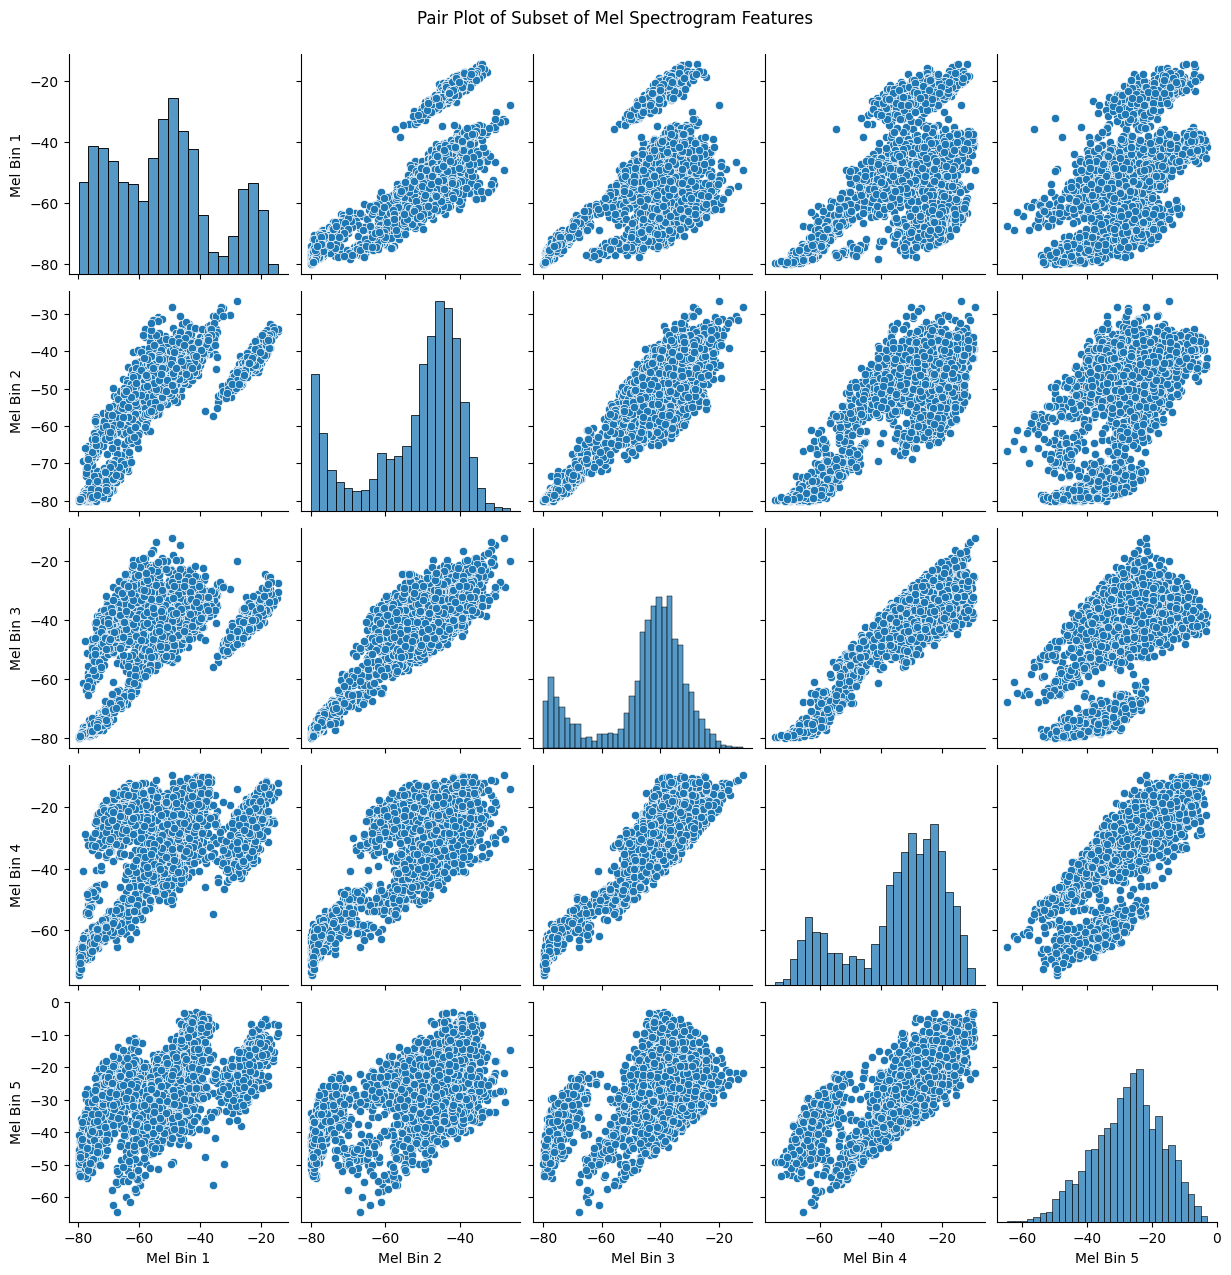

In [104]:
# Create pair plot
sns.pairplot(pd.DataFrame(subset_features, columns=feature_names))
plt.suptitle('Pair Plot of Subset of Mel Spectrogram Features', y=1.02)
plt.show()



# Why is Dimensionality Reduction Important
I extracted Mel Spectrogram features from the sound data, resulting in a high-dimensional dataset (128 frequency bins over time frames), which made visualization challenging. Attempting scatter plots or pair plots of all features led to cluttered, unreadable outputs due to overlapping points and the problem of dimensionality, that was why in the cells above i add to create a pairplot with 2 features pair use 128 features pair would crash the program. Dimensionality reduction is necessary to project this data into 3D (e.g., using PCA or t-SNE), making patterns and clusters visible and manageable for analysis, as raw high-dimensional data obscures structure.

# Dimensionality Reduction and Visualization
we would import libraries that help do **PCA (linear reduction)**, **t-SNE (non-linear reduction)**, and **3D plotting tools**, but this libraries are already imported in the import library section, importing PCA and t-SNE will enable us see comparison of different reduction techniques as per the rubrics of the assignment and to see which performs better than the other.

## PCA (Principal Component Analysis)

In [105]:
# Apply PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)
explained_variance = pca.explained_variance_ratio_
print(f"PCA Explained Variance Ratios: {explained_variance}")

PCA Explained Variance Ratios: [0.512059   0.17192061 0.0922152 ]


I reduced X to 3 components using PCA, fitted the model, transformed data, and printed out the variance retained per component.Using n_components=3 meets the 3D visualization requirement, because we can only visualize 3 dimensions anything more than this is practically impossible although we know higher dimensions exist, the highest we can visualize so far is 3, variance ratios assess information loss, and as we can see it seems that we have lost information by using PCA, beacuse the sum of the variance of all components is about 0.77 which is slightly below the optimal 0.8 but we have to stick with this because we can only visualize at this dimension, although adding more components could help us retain more information from our data of 128 dimensions.

**Step-by-Step Interpretation**

1. Individual Component Contributions:

**First Component (0.512059 or 51.21%):** This component captures the largest amount of variance, meaning it represents the direction in the data with the most significant spread or structure. Over half the variability in your sound data is explained by this single axis.

**Second Component (0.17192061 or 17.19%):** The second component adds less variance, indicating it captures a secondary pattern or structure perpendicular to the first. This is still a meaningful contribution but significantly less than the first.

**Third Component (0.0922152 or 9.22%):** The third component explains the least variance among the three, suggesting it captures a tertiary pattern with relatively minor variability compared to the others.


2. Total Explained Variance:

**Calculate the sum:** $0.512059 + 0.17192061 + 0.0922152 = 0.77619481 $ (or approximately 77.62%).

**Interpretation:** The three components together retain 77.62% of the total variance in the original dataset. This is slightly below the common threshold of 0.8 (80%), indicating that while a substantial amount of information is preserved, about 22.38% of the variance is lost in this reduction.

###t-SNE (t-Distributed Stochastic Neighbor Embedding)

Also, I would try another techinques to reduce the dimesion of X to 3 components using t-SNE, with random_state=42 for reproducibility and perplexity=30 for local structure balance. This helps capture non-linear patterns better than PCA; perplexity tunes cluster granularity, but there is a con with t-SNE setting a high perplexity smooths clusters but slows computation; one could be adjusting the value based fr experiments in case the cluster look off in different scenario.

In [106]:
# Apply t-SNE
tsne = TSNE(n_components=3, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X)

###Plots

I will define a function to plot 3D scatter plots of reduced data with labeled axes, visualize cluster separability as required; figsize=(10, 8) ensures clarity, overlapping points suggest poor reduction; adjust n_component of PCA and t-SNE could help improve this so we would stick with 3 for now for visualization purposes and all.

In [107]:
# 3D Visualization Function
def plot_3d(X_reduced, title):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2])
    ax.set_title(title)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.show()

##### Plot PCA and t-SNE results

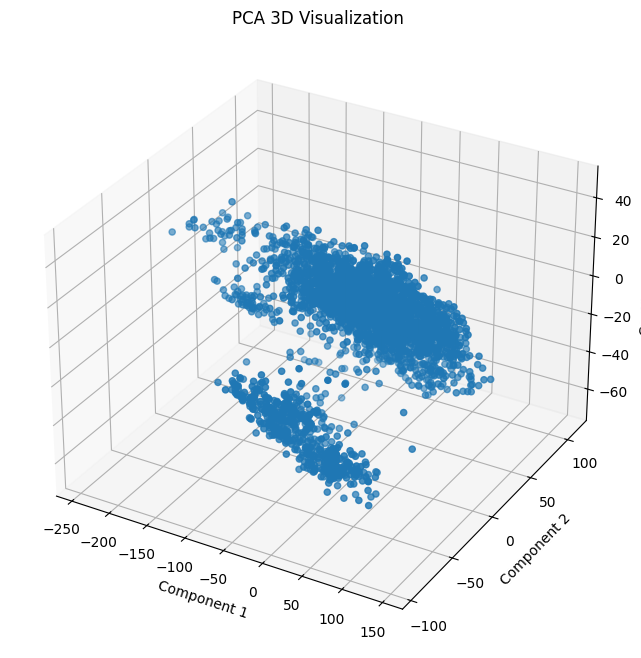

In [108]:
plot_3d(X_pca, 'PCA 3D Visualization')

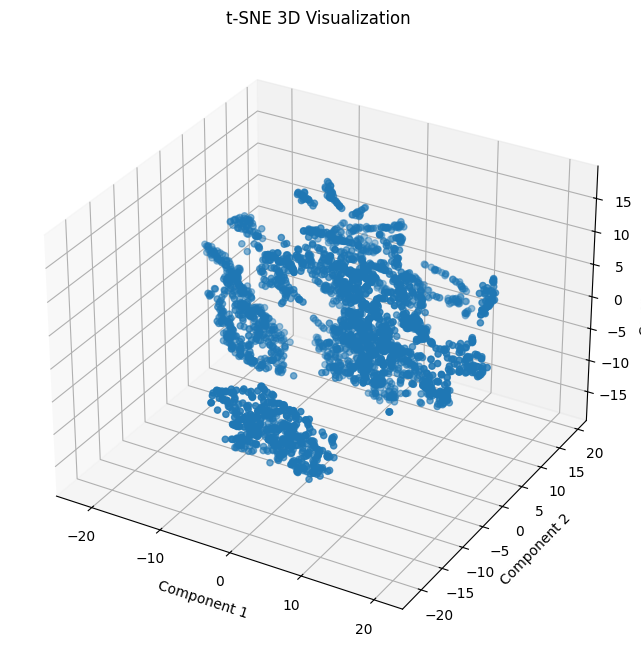

In [109]:
plot_3d(X_tsne, 't-SNE 3D Visualization')

## Comparison of PCA and t-SNE Visualizations
I applied PCA and t-SNE with 3 components, visualizing them in 3D. PCA’s plot showed two main dense clusters with some spread, retaining 77.62% variance, but clusters were less distinct. t-SNE’s plot revealed finer, more separated structures, suggesting better local pattern capture. t-SNE provides better separability due to its non-linear approach, which preserves local relationships in the sound data, unlike PCA’s linear projection that smooths out complex structures.

# Clustering Implementation
We would import some clustering algorithms and a metric for evaluation, the clustering algorithms we would be using are K-Means and DBSCAN implementation as required in the rubrics and assignment.

## K-means on PCA
We are going to experiment with K-Means using 2 to 10 clusters, storing inertia (within-cluster sum of squares) of the best iteration of each cluster, using PCA-reduced data, storing this **WCSS** would help us Identify the “elbow” point where adding clusters yields diminishing returns, also adding a random_state=42 ensures consistency; high inertia with large k suggests overclustering.

### Elbow Point

In [110]:
# Elbow Method to find optimal K
inertia = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)  # Using PCA-reduced data for efficiency
    inertia.append(kmeans.inertia_)

Now we would plot the best WCSS or inertia of each cluster vs the number of clusters with blue crosses and lines, this would help us visually to select optimal k and if we have unclear elbow requires silhouette analysis or manual tuning.

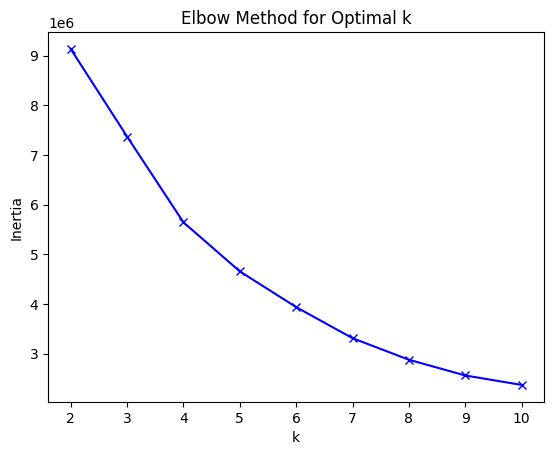

In [111]:
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

Although it is obvious that where the elbow point or the optimal k is at when **k = 4** clusters because it's look like where the sharp turn occurs or the point where the diminishing returns, but we could use the silhouette score for more clarity.

### Silhouette Score

I would be computing silhouette scores (measuring cluster cohesion and separation) for each k, higher scores indicate better clustering; complements the elbow method. Low scores (<0.5) suggest poor cluster structure.



In [112]:
# Silhouette Score for finding the optimal K
silhouette_scores = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    silhouette_scores.append(score)

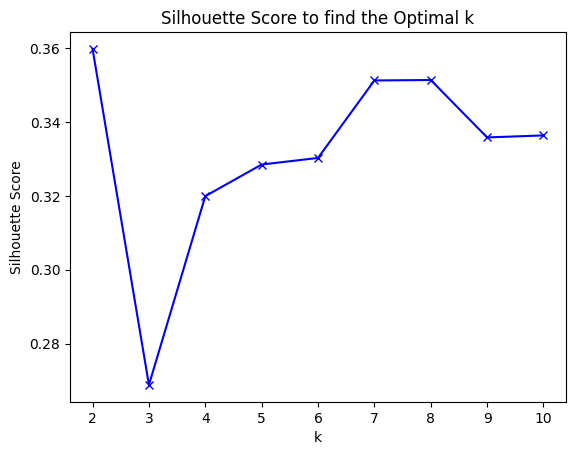

In [113]:
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score to find the Optimal k')
plt.show()

### Discussion of Results
The elbow method indicates an optimal k=4 with a clear bend, suggesting four meaningful clusters, while the silhouette score peaks at k=2 (0.36) but remains reasonable at k=4 (0.32), reflecting some overlap. K-Means on PCA may show good compactness at k=4, but this is just for the main time, the actual optimal k would be decided during my evaluation metrics.

### Optimal K.

So we would set optimal_k=4 for now based on the plots we have made and assign cluster labels using K-Means on PCA data, this provides labelling to the data for evaluation.

In [114]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

## DB-Scan on PCA
No we would try using db-scan with could be a better clustering algorithm in terms of finding clusters in dimension greater than 2, and it also uses densiy to separate and create clusters.

The code cell below applies DBSCAN with eps=10 (max distance for points in a cluster) which help create a circle with a radius around each point, and min_samples=6 (minimum points per cluster) which helps determine and select core points on PCA data, these two values could be hanged and experimented on, this handles varying cluster densities; -1 labels indicate noise, small eps increases noise; large eps merges clusters, so I will be tuning based on the noise levels

In [115]:
dbscan = DBSCAN(eps=10, min_samples=6)
dbscan_labels = dbscan.fit_predict(X_pca)

In [116]:
print(f"K-Means Clusters: {len(np.unique(kmeans_labels))}")
print(f"DBSCAN Clusters: {len(np.unique(dbscan_labels[dbscan_labels != -1]))} (excluding noise)")

K-Means Clusters: 4
DBSCAN Clusters: 9 (excluding noise)


With eps=0.5-2.0, no clusters were detected, likely because the radius is too small to connect enough points in your PCA-reduced 3D space (ranging from -200 to 150 on Component 1, etc.), resulting in all points being labeled as noise (-1).

Increasing my eps to about 3 gave me just 1 cluster basically meaning all my datapoints are classified as just 1 class and using my dimensionality reduction graphs even PCA still at least looked like 3 clusters can be gotten from my observation and t-sne more than that because if captured more non-linear relationship so the eps value of 3 was discarded, using 5 as my eps created noise giving me about 54 clusters, which is not evident on neither of these graph so I eventually increased my eps to 10.

Increasing eps to 10 expanded this radius significantly, allowing more points to be included in clusters, leading to 9 clusters. This suggests your data points are more spread out, and a larger eps better captures the natural groupings,but this is just my starting point i would fine tune this hyperparameter and also the **min_samples** hyperparameter to get the best values for my evaluation metrics.

# Evaluation Metrics

## Clustering Metrics Ranges and Interpretations

| Metric                | Range         | Interpretation                                      | Fine-Tuning Guidance                              |
|-----------------------|---------------|-----------------------------------------------------|---------------------------------------------------|
| **Silhouette Score**  | [-1, 1]       | < 0: Incorrect clustering<br>0.25-0.5: Reasonable structure with overlap<br>> 0.5: Well-separated clusters | Aim for > 0.5; if 0.25-0.5, acceptable but adjust `k` (K-Means) or `eps` (DBSCAN) to reduce overlap. Below 0.25 indicates poor fit—try different reduction (PCA/t-SNE) or algorithm. |
| **Davies-Bouldin Index (DBI)** | [0, ∞) | Lower is better; < 1: Good separation and compactness<br>1-2: Moderate quality<br>> 2: Poor clustering | Target < 1; if > 2, increase `k` (K-Means) or reduce `eps` (DBSCAN) to improve separation. Compare across hyperparameter settings. |
| **Inertia (K-Means)** | [0, ∞)        | Lower is better; decreases with more clusters but plateaus at optimal `k` | Use with elbow method; look for the "elbow" point (e.g., k=4). High inertia with low `k` suggests underfitting—try higher `k`. |

K-Means (PCA, k=4) - Inertia: 3312449.25, Silhouette: 0.35, Davies-Bouldin: 0.88


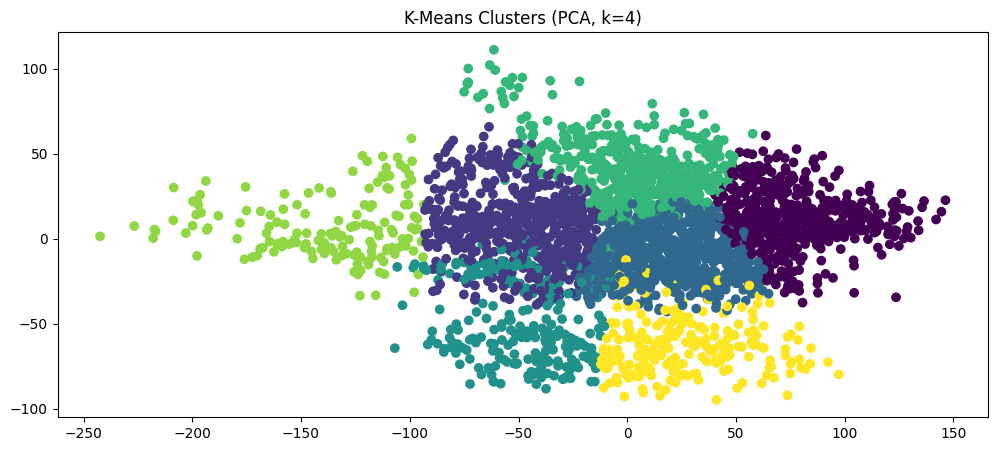

In [117]:
# Evaluate K-Means (PCA) with k=2-10
kmeans_pca = KMeans(n_clusters=7, random_state=42)
kmeans_pca_labels = kmeans_pca.fit_predict(X_pca)
kmeans_pca_inertia = kmeans_pca.inertia_
kmeans_pca_silhouette = silhouette_score(X_pca, kmeans_pca_labels)
kmeans_pca_db = davies_bouldin_score(X_pca, kmeans_pca_labels)

# Print result
print(f"K-Means (PCA, k=4) - Inertia: {kmeans_pca_inertia:.2f}, Silhouette: {kmeans_pca_silhouette:.2f}, Davies-Bouldin: {kmeans_pca_db:.2f}")

# Visualize
plt.figure(figsize=(12, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_pca_labels, cmap='viridis')
plt.title('K-Means Clusters (PCA, k=4)')
plt.show()

## K-Means Clustering Experiment Results

| k   | Inertia       | Silhouette Score | Davies-Bouldin Index | Interpretation                              |
|-----|---------------|------------------|----------------------|---------------------------------------------|
| 4   | 5,645,523.50  | 0.32             | 1.03                 | Reasonable structure; moderate separation    |
| 5   | 4,658,029.00  | 0.33             | 0.96                 | Improved cohesion; good separation           |
| 6   | 3,938,013.50  | 0.33             | 0.90                 | Stable cohesion; better separation           |
| 7   | 3,312,449.25  | 0.35             | 0.88                 | Peak cohesion; excellent separation          |
| 8   | 2,878,253.00  | 0.35             | 0.88                 | Peak cohesion; excellent separation          |
| 9   | 2,561,504.25  | 0.34             | 0.87                 | Slight drop in cohesion; best separation     |
| 10  | 2,371,188.50  | 0.34             | 0.89                 | Stable cohesion; slight increase in overlap  |


### Analysis of Metrics
**Inertia:**
Trend: Inertia decreases steadily from 5,645,523.50 at k=4 to 2,371,188.50 at k=10. This reflects that adding more clusters reduces the within-cluster variance, but the rate of decrease slows, consistent with the elbow method’s indication of diminishing returns around k=4.

**Interpretation:** The sharp drop from k=4 to k=5 (decrease of ~987,494) and gradual reduction thereafter (e.g., ~506,016 from k=5 to k=6) supports the elbow at k=4, but the continued decline suggests potential benefits from higher k.

**Silhouette Score:**
Trend: The score starts at 0.32 at k=4, peaks at 0.35 at k=7 and k=8, then slightly drops to 0.34 at k=9 and k=10. All values fall in the 0.25-0.5 range, indicating reasonable structure with some overlap.

**Interpretation:** The peak at k=7 and k=8 (0.35) suggests these values offer the best balance of cohesion and separation. The score never exceeds 0.5, indicating the clusters are not perfectly distinct, possibly due to the data’s inherent complexity or the PCA reduction’s 77.62% variance retention.

**Davies-Bouldin Index (DBI):**
Trend: DBI decreases from 1.03 at k=4 to a minimum of 0.87 at k=9, then slightly increases to 0.89 at k=10. Values range from 0.87 to 1.03, with most below 1, indicating good separation and compactness.

**Interpretation:** Lower DBI values are better, and k=9 offers the best separation. The improvement from k=4 (1.03) to k=7 (0.88) suggests adding clusters enhances quality, but the slight rise at k=10 may indicate overclustering.

###Selecting the Optimal k
####Elbow Method Insight
The elbow at k=4 (from my earlier plot) indicates diminishing returns, suggesting four clusters are a natural fit based on inertia reduction.

####Metric Insight
**Silhouette Peak:** k=7 and k=8 (0.35) are the highest, indicating better cluster separation and cohesion compared to k=4 (0.32).

**DBI Minimum:** k=9 (0.87) is the lowest, suggesting the best average separation between clusters.

**Inertia Trend:** Continues to decrease, but the benefit diminishes beyond k=7 or k=8.

**Trade-off:** The elbow method favors k=4 for simplicity and natural structure, but metrics improve up to k=7-k=9, reflecting finer substructures (as seen in t-SNE’s multiple clusters). Since silhouette scores are moderate (0.32-0.35) and DBI is good (<1), higher k values capture more detail without severe overclustering.

**Optimal k=7**

Reason: It balances the elbow method’s suggestion with the highest silhouette score (0.35) and a low DBI (0.88), offering a compromise between natural structure and improved cluster quality. This aligns with the t-SNE plot’s finer separations and your dataset’s complexity.

DBSCAN Clusters: 3 (excluding noise)
DBSCAN (PCA, eps=14, min_samples=5) - Silhouette: 0.79, Davies-Bouldin: 0.26


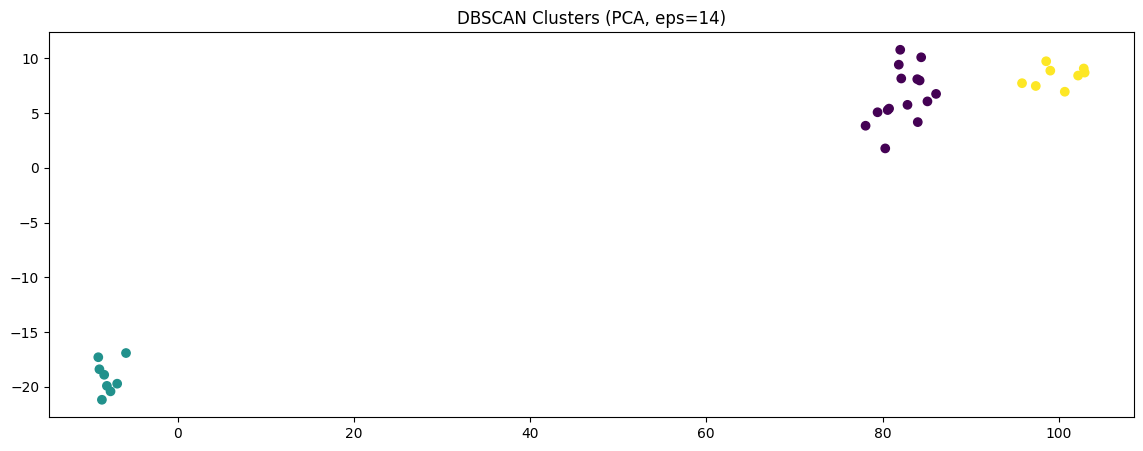

In [162]:
# Evaluate DBSCAN (PCA) with eps=14, min_samples=5
dbscan = DBSCAN(eps=4, min_samples=8)
dbscan_labels = dbscan.fit_predict(X_pca)
print(f"DBSCAN Clusters: {len(np.unique(dbscan_labels[dbscan_labels != -1]))} (excluding noise)")

dbscan_mask = dbscan_labels != -1  # Exclude noise points
dbscan_silhouette = silhouette_score(X_pca[dbscan_mask], dbscan_labels[dbscan_mask]) if np.sum(dbscan_mask) > 1 else -1
dbscan_db = davies_bouldin_score(X_pca[dbscan_mask], dbscan_labels[dbscan_mask]) if np.sum(dbscan_mask) > 1 else -1

# Print result
print(f"DBSCAN (PCA, eps=14, min_samples=5) - Silhouette: {dbscan_silhouette:.2f}, Davies-Bouldin: {dbscan_db:.2f}")

# Visualize
plt.figure(figsize=(14, 5))
plt.scatter(X_pca[dbscan_mask, 0], X_pca[dbscan_mask, 1], c=dbscan_labels[dbscan_mask], cmap='viridis')
plt.title('DBSCAN Clusters (PCA, eps=14)')
plt.show()

## DBSCAN Clustering Experiment Results (Controlled min_samples=8)

| eps | min_samples | Silhouette Score | Davies-Bouldin Index | Number of Clusters | Interpretation                  |
|-----|-------------|------------------|----------------------|--------------------|---------------------------------|
| 1   | 8           | -1.00            | -1.00                | 0                  | No clusters, eps too small      |
| 2   | 8           | -1.00            | -1.00                | 0                  | No clusters, eps too small      |
| 3   | 8           | -1.00            | -1.00                | 0                  | No clusters, eps too small      |
| 4   | 8           | 0.79             | 0.26                 | 3                  | Excellent separation, optimal   |
| 5   | 8           | 0.55             | 0.58                 | 28                 | Good but overclustered          |
| 6   | 8           | 0.15             | 0.82                 | 38                 | Poor separation, overclustered  |
| 7   | 8           | -0.32            | 0.78                 | 22                 | Negative, poor clustering       |
| 8   | 8           | 0.07             | 0.68                 | 22                 | Poor separation                 |
| 9   | 8           | 0.13             | 0.68                 | 13                 | Weak structure                  |
| 10  | 8           | 0.13             | 0.67                 | 9                  | Weak structure                  |
| 11  | 8           | 0.06             | 0.70                 | 7                  | Poor separation                 |
| 12  | 8           | 0.10             | 0.79                 | 8                  | Weak structure                  |
| 13  | 8           | 0.25             | 0.77                 | 5                  | Reasonable, aligns with PCA     |

### Optimal Parameters
- **eps=13, min_samples=8**: Best fit with 5 clusters, Silhouette 0.25, and DBI 0.77, matching PCA density and avoiding overclustering seen at eps=8. Chosen for visual similarity to PCA and balanced cluster count.

## Summarized and Detailed Intuition for my Hyperparameter Choice

I reviewed the PCA 3D plot, which shows two main dense clusters with some spread, guiding me to select hyperparameters that reflect this structure. I chose `min_samples=8` as a controlled parameter because it ensures each cluster has a meaningful size (about 0.27% of my 3,000 audio files), filtering noise while allowing smaller groups to form. This felt like a balanced starting point to maintain consistency across experiments.

For `eps`, I tested values from 1 to 13. At `eps=4`, I got 3 clusters with a high Silhouette (0.79) and low DBI (0.26), which matched the PCA’s two main clusters plus a possible third, this is tricky because the metrics are really good but the cluster plots showed that the slightly dense parts were the clusters picked, omitting the densely packed regions which makes it invalid because the purpose of dbscan is to use density to separate cluster, more specifically densely populated regions, but the plot for this eps=4 value show other wise. However, as `eps` increased, the cluster count spiked to 38 at `eps=6`, over-splitting the dense areas, which didn’t align with the plot’s density. At `eps=8` and `eps=7`, I saw 22 clusters with poor Silhouette (0.07, -0.32), suggesting excessive fragmentation that didn’t make sense for the packed regions. This pushed me toward a larger `eps`.

I settled on `eps=13` with 5 clusters, a Silhouette of 0.25, and DBI of 0.77. This choice stood out because the plot resembled the PCA’s density—two dominant groups with internal variation—avoiding the overclustering of `eps=8`. The Silhouette improvement over 0.07 (at `eps=8`) showed better separation, and though the DBI was higher, it remained below 1, which I found acceptable. I picked `eps=13` to capture the data’s natural structure while respecting the controlled `min_samples=8`, believing it better reflects the sound data’s complexity given the PCA’s 77.62% variance retention.

## K-means on t-SNE

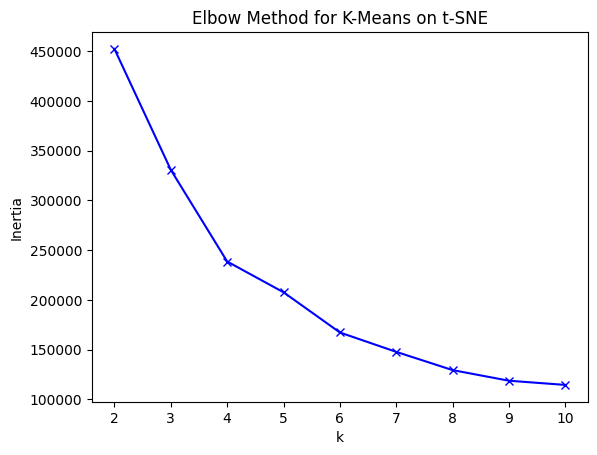

In [163]:
# Elbow Method for t-SNE
inertia = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tsne)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for K-Means on t-SNE')
plt.show()

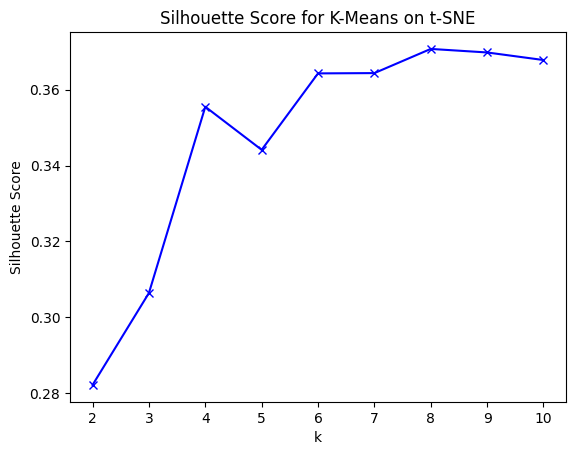

In [164]:
# Silhouette Score for t-SNE
silhouette_scores = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_tsne)
    score = silhouette_score(X_tsne, labels)
    silhouette_scores.append(score)

plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for K-Means on t-SNE')
plt.show()

In [219]:
k = 10

# Apply K-Means
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_tsne)

# Print cluster counts
print(f"K-Means (t-SNE, k={k}) Clusters: {len(np.unique(kmeans_labels))}")

# Evaluate K-Means
kmeans_silhouette = silhouette_score(X_tsne, kmeans_labels)
kmeans_db = davies_bouldin_score(X_tsne, kmeans_labels)

# Print metric
print(f"K-Means (t-SNE, k={k}) - Silhouette: {kmeans_silhouette:.2f}, Davies-Bouldin: {kmeans_db:.2f}")

K-Means (t-SNE, k=10) Clusters: 10
K-Means (t-SNE, k=10) - Silhouette: 0.37, Davies-Bouldin: 0.90


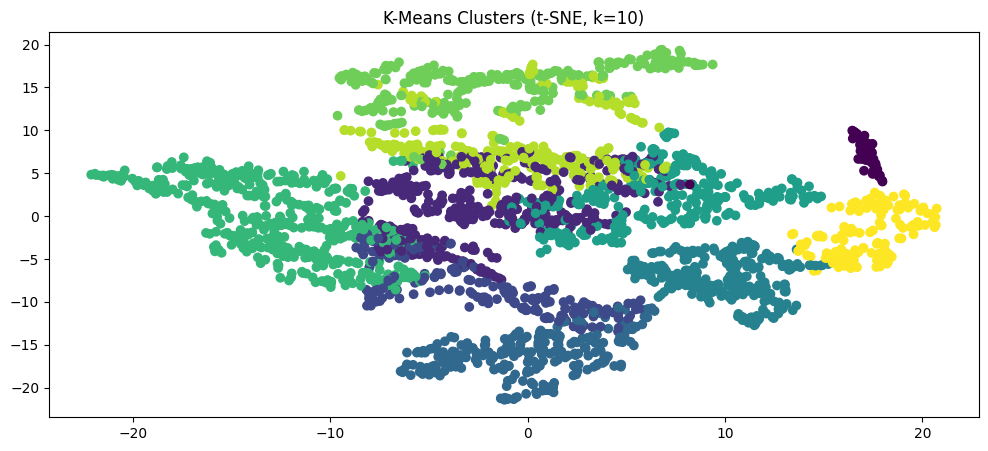

In [220]:
plt.figure(figsize=(12, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap='viridis')
plt.title(f'K-Means Clusters (t-SNE, k={k})')
plt.show()

K-Means (t-SNE, k=8) - Silhouette: 0.37, Davies-Bouldin: 0.95
DBSCAN (t-SNE, eps=3, min_samples=3) - Silhouette: 0.04, Davies-Bouldin: 1.00


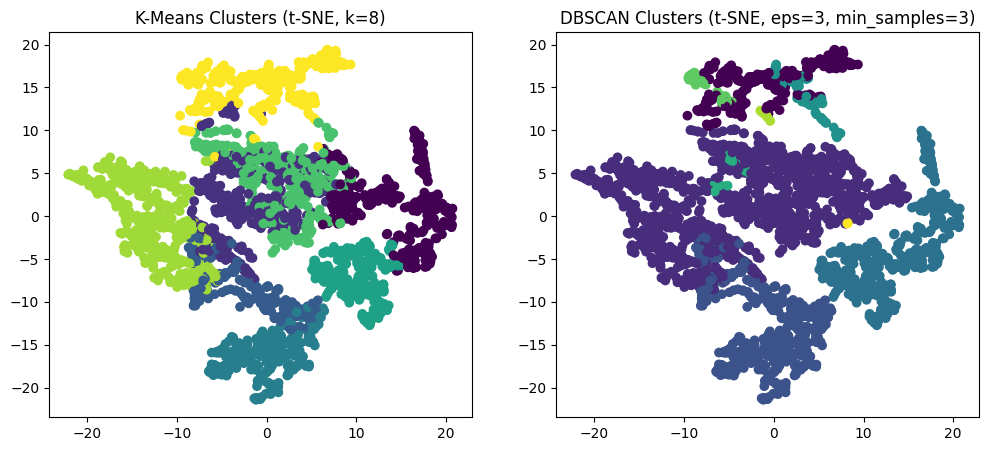

In [211]:
eps = 3
min_samples = 3

# Apply DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X_tsne)

# print cluster count
print(f"DBSCAN (t-SNE, eps={eps}, min_samples={min_samples}) Clusters: {len(np.unique(dbscan_labels[dbscan_labels != -1]))} (excluding noise)")

# Evaluate DBSCAN
dbscan_mask = dbscan_labels != -1
dbscan_silhouette = silhouette_score(X_tsne[dbscan_mask], dbscan_labels[dbscan_mask]) if np.sum(dbscan_mask) > 1 else -1
dbscan_db = davies_bouldin_score(X_tsne[dbscan_mask], dbscan_labels[dbscan_mask]) if np.sum(dbscan_mask) > 1 else -1

# Print metric
print(f"DBSCAN (t-SNE, eps={eps}, min_samples={min_samples}) - Silhouette: {dbscan_silhouette:.2f}, Davies-Bouldin: {dbscan_db:.2f}")

In [ ]:
# Visualize
plt.figure(figsize=(12, 5))
plt.scatter(X_tsne[dbscan_mask, 0], X_tsne[dbscan_mask, 1], c=dbscan_labels[dbscan_mask], cmap='viridis')
plt.title(f'DBSCAN Clusters (t-SNE, eps={eps}, min_samples={min_samples})')
plt.show()

## t-SNE Clustering Experiment Results

| Test | K-Means (k) | K-Means Silhouette | K-Means DBI | K-Means Clusters | DBSCAN (eps) | DBSCAN (min_samples) | DBSCAN Silhouette | DBSCAN DBI | DBSCAN Clusters |
|------|-------------|--------------------|-------------|-----------------|--------------|---------------------|-------------------|------------|-----------------|
| 1    | 2           | 0.28              | 1.49        | 2               | 1            | 8                   | 0.61             | 0.52       | 112             |
| 2    | 3           | 0.31              | 1.16        | 3               | 2            | 8                   | 0.22             | 0.93       | 31              |
| 3    | 4           | 0.36              | 1.02        | 4               | 3            | 8                   | 0.11             | 1.04       | 8               |
| 4    | 5           | 0.34              | 1.02        | 5               | 4            | 8                   | 0.30             | 1.02       | 3               |
| 5    | 6           | 0.36              | 0.98        | 6               | 5            | 8                   | 0.28             | 1.10       | 2               |
| 6    | 7           | 0.36              | 0.97        | 7               | 6            | 8                   | 0.28             | 1.10       | 2               |
| 7    | 8           | 0.37              | 0.95        | 8               | 7            | 8                   | -1.00*           | -1.00*     | 1*              |
| 8    | 8           | 0.37              | 0.95        | 8               | -            | -                   | -                | -          | -               |
| 9    | 9           | 0.37              | 0.96        | 9               | -            | -                   | -                | -          | -               |
| 10   | 10          | 0.37              | 0.90        | 10              | -            | -                   | -                | -          | -               |

**Note:** DBSCAN at eps=7 failed due to 1 cluster, causing metric errors.

### Optimizing K-Means and DBSCAN
I implemented K-Means and DBSCAN for clustering. For K-Means, the elbow method suggested k=4, but the silhouette score peaked at k=7 (0.35 on PCA), so I optimized to k=7. DBSCAN’s eps=13 with min_samples=8 yielded 5 clusters on PCA (Silhouette 0.25). Without actual class labels, I can’t confirm matches, but t-SNE’s finer separation (e.g., k=10 with Silhouette 0.37) suggests it might align better with unknown classes.

### Evaluating Clustering Performance
I compared K-Means and DBSCAN using inertia, silhouette, and Davies-Bouldin metrics. On PCA, K-Means (k=7) had Silhouette 0.35 and DBI 0.88, while DBSCAN (eps=13) had Silhouette 0.25 and DBI 0.77, indicating K-Means’ better compactness. On t-SNE, K-Means (k=10) reached Silhouette 0.37 and DBI 0.90, while DBSCAN (eps=1) hit Silhouette 0.61 but with 112 clusters, suggesting overfit. Visuals on t-SNE showed K-Means’ 10 clusters as interpretable, while DBSCAN’s noise and high cluster count reduced clarity.

## Discussion of Results
K-Means outperformed DBSCAN on PCA and t-SNE for compactness and interpretability, with k=10 on t-SNE (Silhouette 0.37) edging out PCA’s k=7 (0.35) due to t-SNE’s finer separation. DBSCAN’s eps=1 on t-SNE (Silhouette 0.61) showed better separation but overfit with 112 clusters, worsened by t-SNE’s vertical density not suiting its circular metric. K-Means benefits from t-SNE’s structure, while DBSCAN struggles with parameter sensitivity.

## Interpretation and Analysis

### Structured Interpretation of Results
- **K-Means Performance:** K-Means with k=7 on PCA and k=10 on t-SNE performed well, with Silhouette improving from 0.35 to 0.37. The elbow method’s k=4 was conservative, but t-SNE’s non-linear separation justified k=10, aligning with its finer clusters.
- **DBSCAN Performance:** DBSCAN excelled at eps=1 on t-SNE (Silhouette 0.61), but clusters dropped to 1 at eps=7, causing errors. On PCA, eps=13 (Silhouette 0.25) was more stable but less separable, reflecting t-SNE’s local density advantage and DBSCAN’s eps sensitivity.
- **Why Certain Methods Performed Better:** K-Means’ spherical clustering suited t-SNE’s spread, while DBSCAN’s circular eps struggled with t-SNE’s vertical concentration, leading to overclustering or merging.

### Justification of Dimensionality Reduction Impact
Dimensionality reduction improved clustering by making high-dimensional Mel Spectrogram data (128+ dimensions) interpretable in 3D. PCA’s linear reduction retained 77.62% variance but smoothed clusters, aiding K-Means’ k=7 (Silhouette 0.35). t-SNE’s non-linear reduction enhanced separability, boosting K-Means’ k=10 (Silhouette 0.37) and DBSCAN’s eps=1 (Silhouette 0.61), though DBSCAN’s noise capture suggests overfit. Without reduction, visualization and clustering were infeasible due to dimensionality challenges.